## Low-level benchmarks

The "low-level" benchmarks correspond to circuits composed of only one type of gate, with various "depths" (i.e. numbers of nested gates).   
For example, ```circuit-ADD-3.sheep``` contains three nested "ADD" gates: ```output=((a+b)+c)+d```.

This notebook consists of several "scans" of parameter space.  For each scan, some functions in ```benchmark_utils``` will be run to configure and run the HE libraries (this may take some time) and then there will be some analysis of the results. 

The code in this notebook should be run from the base SHEEP directory.
Dependencies are:
* pandas
* numpy
* matplotlib
* sqlalchemy

In [1]:
import os
import sys
if not "SHEEP_HOME" in os.environ.keys():
    print("Please set environment variable SHEEP_HOME to point to the location of SHEEP/frontend")
sys.path.append(os.environ["SHEEP_HOME"])
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pysheep.low_level_benchmarks import params_for_level, run_circuit

## Scan 1 
Look at the "levelled" HE libraries (HElib_Fp and SEAL), where we can set parameters that should guarantee correct results on a certain "depth" (i.e. number of MULTIPLY operations) without the need for bootstrapping.  
We will try two depth settings - 1 and 10 (note that the parameter choices for SEAL are not very granular).  For each depth setting, we loop over all gates and all input types, and measure the execution time.

In [2]:
CIRCUIT_FILE_DIR = os.path.join(os.environ["SHEEP_HOME"],"benchmark_inputs","low_level","circuits")
## give a unique scan_id so that we can retrieve the results later on
import uuid
scan_id = str(uuid.uuid4())
## look at unsigned 8-bit integers
input_type = "uint8_t"
## start looping over gates, depths, and contexts
for gate in ["ADD","SUBTRACT","MULTIPLY","SELECT","NEGATE"]:
    for d in [1,10]:
        for context in ["HElib_Fp","SEAL"]:
            params = params_for_level(context,d)
            circuit_file = CIRCUIT_FILE_DIR+"/circuit-"+gate+"-1.sheep"
            print("Doing benchmark for %s %s %s %i" %
                            (context,gate,input_type,d))
            uploaded_OK = run_circuit(circuit_file,
                                                input_type,
                                                context,
                                                params,
                                                "serial",
                                                scan_id)
            if not uploaded_OK:
                print("Problem running test or uploading result")
if uploaded_OK:
    print("Finished OK")

Doing benchmark for HElib_Fp ADD uint8_t 1
Doing benchmark for SEAL ADD uint8_t 1
Doing benchmark for HElib_Fp ADD uint8_t 10
Doing benchmark for SEAL ADD uint8_t 10
Doing benchmark for HElib_Fp SUBTRACT uint8_t 1
Doing benchmark for SEAL SUBTRACT uint8_t 1
Doing benchmark for HElib_Fp SUBTRACT uint8_t 10
Doing benchmark for SEAL SUBTRACT uint8_t 10
Doing benchmark for HElib_Fp MULTIPLY uint8_t 1
Doing benchmark for SEAL MULTIPLY uint8_t 1
Doing benchmark for HElib_Fp MULTIPLY uint8_t 10
Doing benchmark for SEAL MULTIPLY uint8_t 10
Doing benchmark for HElib_Fp SELECT uint8_t 1
Doing benchmark for SEAL SELECT uint8_t 1
Doing benchmark for HElib_Fp SELECT uint8_t 10
Doing benchmark for SEAL SELECT uint8_t 10
Doing benchmark for HElib_Fp NEGATE uint8_t 1
Doing benchmark for SEAL NEGATE uint8_t 1
Doing benchmark for HElib_Fp NEGATE uint8_t 10
Doing benchmark for SEAL NEGATE uint8_t 10
Finished OK


### Tabulating and plotting the results

Import some SQLAlchemy utilities from the SHEEP frontend code.

In [3]:
from pysheep.database import BenchmarkMeasurement, session
from pysheep.benchmark_utils import levels_for_params
from pysheep.low_level_benchmarks import get_gate_name_from_circuit_name

In [4]:
rows_scan1 = session.query(BenchmarkMeasurement).filter_by(scan_id=scan_id).all()

The parameters and timings should now be stored in an sqlite file.
We will query this using SQLAlchemy, put the results into a Pandas DataFrame, and then make some plots.
First, define a dictionary with keys being the columns we want:

In [28]:
dict_scan1 = {"context":[],"gate":[],"input_bitwidth":[],"input_signed":[],"is_correct":[],"level":[], "execution_time":[]}

Now define a couple of functions to query the database and fill the table

In [29]:
def get_levels_for_row(benchmark_measurement):
    ## do the reverse lookup of params_for_level
    context = benchmark_measurement.context
    param_dict = {}
    for param in benchmark_measurement.parameters:
        param_dict[param.param_name] = param.param_value
    return levels_for_params(benchmark_measurement.context,param_dict)

def get_depth_for_row(benchmark_measurement):
    ## parse the circuit filename and see how many nested gates there were 
    return re.search("-([\d]+).sheep",benchmark_measurement.circuit_name).groups()[0]


def get_execution_time_for_row(benchmark_measurement):
    for timing in benchmark_measurement.timings:
        if timing.timing_name == "evaluation":
            return timing.timing_value

def fill_row(benchmark_measurement, columns):
    columns["context"].append(benchmark_measurement.context)
    columns["gate"].append(get_gate_name_from_circuit_name(benchmark_measurement.circuit_name))
    columns["input_bitwidth"].append(benchmark_measurement.input_bitwidth)
    columns["input_signed"].append(benchmark_measurement.input_signed)
    columns["is_correct"].append(benchmark_measurement.is_correct)
    if "level" in columns.keys():
        columns["level"].append(get_levels_for_row(benchmark_measurement))
    if "depth" in columns.keys():
        columns["depth"].append(get_depth_for_row(benchmark_measurement))
    columns["execution_time"].append(get_execution_time_for_row(benchmark_measurement))
    return columns

In [30]:
for row in rows_scan1:
    dict_scan1 = fill_row(row,dict_scan1)
df_scan1 = pd.DataFrame(dict_scan1)
df_scan1

,context,execution_time,gate,input_bitwidth,input_signed,is_correct,level
0,HElib_Fp,137.0,ADD,8,False,True,1
1,SEAL,138.4,ADD,8,False,True,1
2,HElib_Fp,192.4,ADD,8,False,True,10
3,SEAL,469.2,ADD,8,False,True,10
4,HElib_Fp,137.1,SUBTRACT,8,False,True,1
5,SEAL,140.5,SUBTRACT,8,False,False,1
6,HElib_Fp,193.8,SUBTRACT,8,False,True,10
7,SEAL,445.9,SUBTRACT,8,False,False,10
8,HElib_Fp,1236.4,MULTIPLY,8,False,False,1
9,SEAL,1811.1,MULTIPLY,8,False,False,1


Now lets plot the execution time vs depth for each gate type for 8-bit integers


In [52]:
def execution_time_vs_x_cat(input_dataframe, gate_name, bitwidth, is_signed, libs_list, x_var="context",category_var=None):
    ## plot execution time for different contexts vs category var (e.g. "depth", "levels")
    rows = input_dataframe[(input_dataframe.input_bitwidth==bitwidth) & 
                           (input_dataframe.gate==gate_name) & 
                           input_dataframe.context.isin(libs_list) & 
                           (input_dataframe.input_signed==is_signed)
                          ]
 #   return rows
    if category_var:
        return rows.drop_duplicates([x_var, category_var]).pivot(
            index=x_var, columns=category_var, values='execution_time')
    else:
        return rows.drop_duplicates([x_var]).pivot(
            index=x_var, values='execution_time')
    

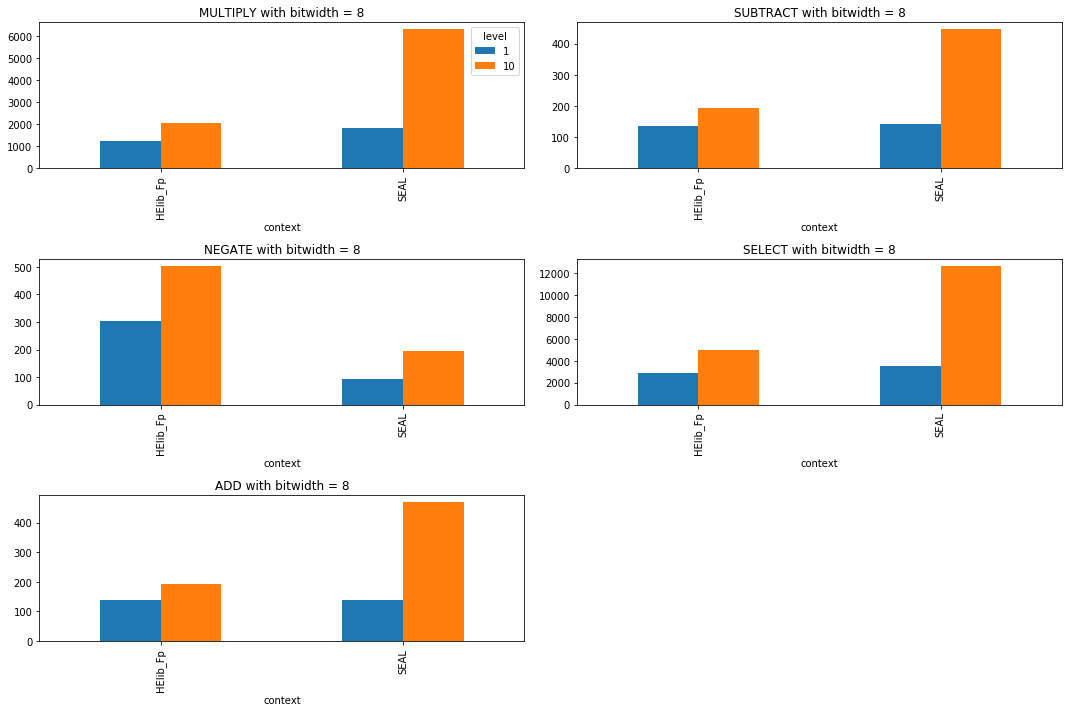

In [43]:
all_ops = set(df_scan1.gate)
bitwidth = 8
is_signed = False
for i, op in enumerate(all_ops):
    if op == "COMPARE": continue 
    libs = ["HElib_Fp", "SEAL"]
    plot_scan1 = execution_time_vs_x_cat(df_scan1, op, bitwidth, is_signed, libs, "context","level")
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
#     axis.set_yscale("log")
    plot_scan1.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

# Scan 2: 
Set parameters for the "leveled" libraries (HElib_Fp and SEAL) to be able to support multiplicative depth of 4, then see how many additions or multiplications we can do and still get the correct results.

In [33]:
scan_id = str(uuid.uuid4())
## look at bool inputs
input_type = "bool"
## start looping over gates, depths, and contexts
for gate in ["ADD","MULTIPLY","SUBTRACT","NEGATE"]:
    for context in ["HElib_Fp","SEAL"]:
        params = params_for_level(context,4)
        for d in range(1,9):
            circuit_file = CIRCUIT_FILE_DIR+"/circuit-"+gate+"-"+str(d)+".sheep"
            print("Doing benchmark for %s %s %s %i" %
                            (context,gate,input_type,d))
            uploaded_OK = run_circuit(circuit_file,
                                      input_type,
                                      context,
                                      params,
                                      "serial",
                                      scan_id,
                                      timeout=60)
            if not uploaded_OK:
                print("Problem running test or uploading result")
if uploaded_OK:
    print("Finished OK")

Doing benchmark for HElib_Fp ADD bool 1
Doing benchmark for HElib_Fp ADD bool 2
Doing benchmark for HElib_Fp ADD bool 3
Doing benchmark for HElib_Fp ADD bool 4
Doing benchmark for HElib_Fp ADD bool 5
Doing benchmark for HElib_Fp ADD bool 6
Doing benchmark for HElib_Fp ADD bool 7
Doing benchmark for HElib_Fp ADD bool 8
Doing benchmark for SEAL ADD bool 1
Doing benchmark for SEAL ADD bool 2
Doing benchmark for SEAL ADD bool 3
Doing benchmark for SEAL ADD bool 4
Doing benchmark for SEAL ADD bool 5
Doing benchmark for SEAL ADD bool 6
Doing benchmark for SEAL ADD bool 7
Doing benchmark for SEAL ADD bool 8
Doing benchmark for HElib_Fp MULTIPLY bool 1
Doing benchmark for HElib_Fp MULTIPLY bool 2
Doing benchmark for HElib_Fp MULTIPLY bool 3
Doing benchmark for HElib_Fp MULTIPLY bool 4
Doing benchmark for HElib_Fp MULTIPLY bool 5
Doing benchmark for HElib_Fp MULTIPLY bool 6
Doing benchmark for HElib_Fp MULTIPLY bool 7
Doing benchmark for HElib_Fp MULTIPLY bool 8
Doing benchmark for SEAL MULTIPL

### Tabulate and plot the results

In [34]:
rows_scan2 = session.query(BenchmarkMeasurement).filter_by(scan_id=scan_id).filter_by(is_correct=True).all()
dict_scan2 = {"context":[],"gate":[],"input_bitwidth":[],"input_signed":[],"is_correct":[],"depth":[], "execution_time":[]}
for row in rows_scan2:
    dict_scan2= fill_row(row,dict_scan2)
    
df_scan2 = pd.DataFrame(dict_scan2)
df_scan2.head()

,context,depth,execution_time,gate,input_bitwidth,input_signed,is_correct
0,HElib_Fp,1,162.8,ADD,1,False,True
1,HElib_Fp,2,302.0,ADD,1,False,True
2,HElib_Fp,3,398.6,ADD,1,False,True
3,HElib_Fp,4,517.4,ADD,1,False,True
4,HElib_Fp,5,633.6,ADD,1,False,True


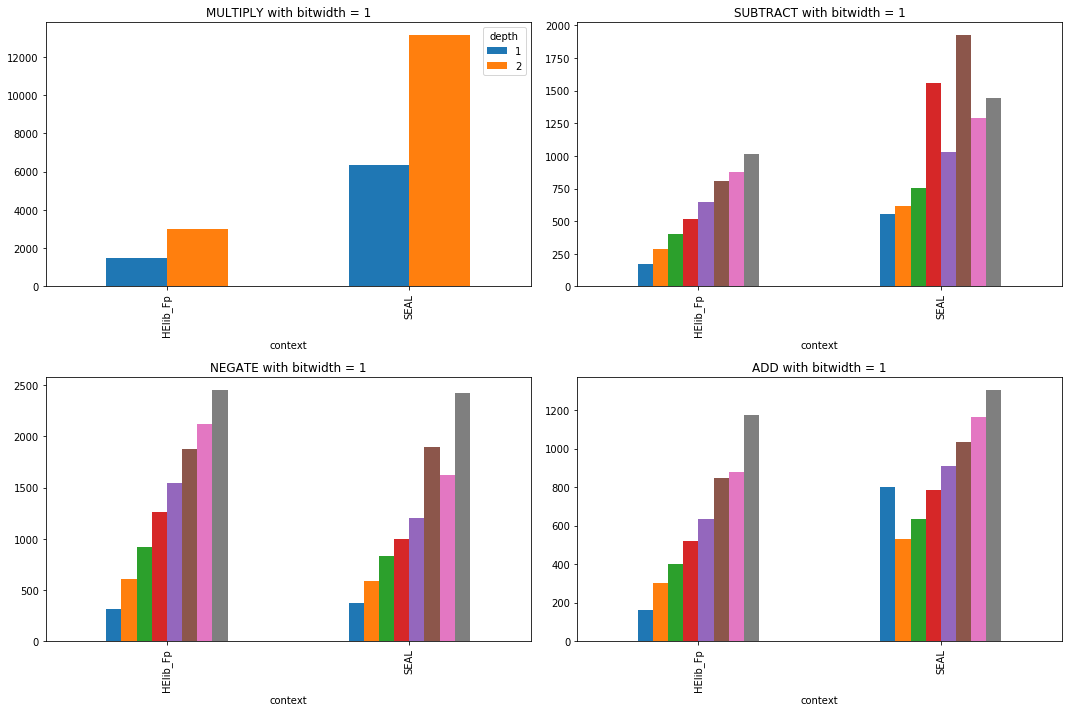

In [44]:
all_ops = set(df_scan2.gate)
bitwidth = 1
is_signed = False
for i, op in enumerate(all_ops):
    libs = ["HElib_Fp", "SEAL"]
    plot_scan2 = execution_time_vs_x_cat(df_scan2, op, bitwidth, is_signed, libs,"context","depth")
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
#     axis.set_yscale("log")
    plot_scan2.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

We can see that we can do multiple iterations of most types of operation and still get the correct result, but for MULTIPLY, the noise quickly grows to the extent that we get incorrect results.

## Scan 3

Compare all libraries for all supported gates, on bool inputs.

In [61]:
scan_id = str(uuid.uuid4())
## look at bool inputs
input_type = "bool"
## start looping over gates, depths, and contexts
for gate in ["ADD","MULTIPLY","SUBTRACT","SELECT"]:
    for context in ["HElib_Fp","HElib_F2","SEAL","TFHE","LP"]:
        ## skip context/gate combinations that are not supported
        if context == "LP" and gate in ["MULTIPLY","SUBTRACT","SELECT"]:
            continue
        params = params_for_level(context,2)
        circuit_file = CIRCUIT_FILE_DIR+"/circuit-"+gate+"-1.sheep"
        print("Doing benchmark for %s %s %s" %
                            (context,gate,input_type))
        uploaded_OK = run_circuit(circuit_file,
                                  input_type,
                                  context,
                                  params,
                                  "serial",
                                  scan_id,
                                  timeout=60)
        if not uploaded_OK:
            print("Problem running test or uploading result")
if uploaded_OK:
    print("Finished OK")

Doing benchmark for HElib_Fp ADD bool
Doing benchmark for HElib_F2 ADD bool
Doing benchmark for SEAL ADD bool
Doing benchmark for TFHE ADD bool
Doing benchmark for LP ADD bool
Doing benchmark for HElib_Fp MULTIPLY bool
Doing benchmark for HElib_F2 MULTIPLY bool
Doing benchmark for SEAL MULTIPLY bool
Doing benchmark for TFHE MULTIPLY bool
Doing benchmark for HElib_Fp SUBTRACT bool
Doing benchmark for HElib_F2 SUBTRACT bool
Doing benchmark for SEAL SUBTRACT bool
Doing benchmark for TFHE SUBTRACT bool
Doing benchmark for HElib_Fp SELECT bool
Doing benchmark for HElib_F2 SELECT bool
Doing benchmark for SEAL SELECT bool
Doing benchmark for TFHE SELECT bool
Finished OK


In [62]:
rows_scan3 = session.query(BenchmarkMeasurement).filter_by(scan_id=scan_id).all()
dict_scan3 = {"context":[],"gate":[],"input_bitwidth":[],"input_signed":[],"is_correct":[], "execution_time":[]}
for row in rows_scan3:
    dict_scan3 = fill_row(row,dict_scan3)
    
df_scan3 = pd.DataFrame(dict_scan3)
df_scan3

,context,execution_time,gate,input_bitwidth,input_signed,is_correct
0,HElib_Fp,152.6,ADD,1,False,True
1,HElib_F2,2438.2,ADD,1,False,True
2,SEAL,418.9,ADD,1,False,True
3,TFHE,21976.6,ADD,1,False,True
4,LP,49.4,ADD,1,False,True
5,HElib_Fp,1257.8,MULTIPLY,1,False,True
6,HElib_F2,5181.1,MULTIPLY,1,False,True
7,SEAL,6422.4,MULTIPLY,1,False,True
8,TFHE,21931.9,MULTIPLY,1,False,True
9,HElib_Fp,152.6,SUBTRACT,1,False,True


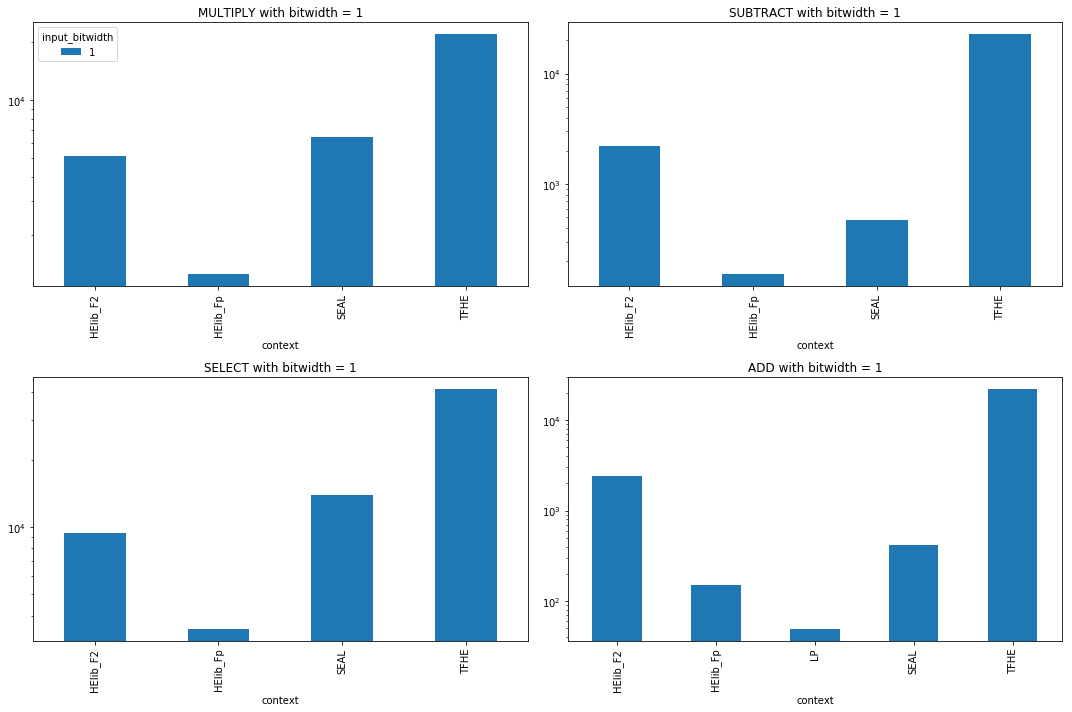

In [63]:
all_ops = set(df_scan3.gate)
bitwidth = 1
is_signed = False
for i, op in enumerate(all_ops):
    libs = ["HElib_Fp", "HElib_F2","TFHE","SEAL","LP"]
    plot_scan3 = execution_time_vs_x_cat(df_scan3, op, bitwidth, is_signed, libs,"context",category_var="input_bitwidth")
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
    axis.set_yscale("log")
    plot_scan3.plot(ax=axis, title=op + ' with bitwidth = ' + str(bitwidth), kind='bar', figsize=(15, 10), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()

# Scan 4:
Look at how bitwidth of the input type affects the execution time.  Use circuits with a single gate.

In [64]:
scan_id = str(uuid.uuid4())
input_type = "bool"
## start looping over gates, depths, and contexts
for gate in ["ADD","MULTIPLY"]:
    for context in ["HElib_Fp","SEAL","HElib_F2","TFHE"]:
        params = params_for_level(context,2)
        for input_type in ["bool","uint8_t","uint16_t","uint32_t"]:
            circuit_file = CIRCUIT_FILE_DIR+"/circuit-"+gate+"-1.sheep"
            print("Doing benchmark for %s %s %s" %
                            (context,gate,input_type))
            uploaded_OK = run_circuit(circuit_file,
                                      input_type,
                                      context,
                                      params,
                                      "serial",
                                      scan_id,
                                      timeout=600)
            if not uploaded_OK:
                print("Problem running test or uploading result")
if uploaded_OK:
    print("Finished OK")

Doing benchmark for HElib_Fp ADD bool
Doing benchmark for HElib_Fp ADD uint8_t
Doing benchmark for HElib_Fp ADD uint16_t
Doing benchmark for HElib_Fp ADD uint32_t
Doing benchmark for SEAL ADD bool
Doing benchmark for SEAL ADD uint8_t
Doing benchmark for SEAL ADD uint16_t
Doing benchmark for SEAL ADD uint32_t
Doing benchmark for HElib_F2 ADD bool
Doing benchmark for HElib_F2 ADD uint8_t
Doing benchmark for HElib_F2 ADD uint16_t
Doing benchmark for HElib_F2 ADD uint32_t
Doing benchmark for TFHE ADD bool
Doing benchmark for TFHE ADD uint8_t
Doing benchmark for TFHE ADD uint16_t
Doing benchmark for TFHE ADD uint32_t
Doing benchmark for HElib_Fp MULTIPLY bool
Doing benchmark for HElib_Fp MULTIPLY uint8_t
Doing benchmark for HElib_Fp MULTIPLY uint16_t
Doing benchmark for HElib_Fp MULTIPLY uint32_t
Doing benchmark for SEAL MULTIPLY bool
Doing benchmark for SEAL MULTIPLY uint8_t
Doing benchmark for SEAL MULTIPLY uint16_t
Doing benchmark for SEAL MULTIPLY uint32_t
Doing benchmark for HElib_F2 M

HElib_F2 and TFHE both deal with binary arrays, and by default bootstrap for every operation, while we expect HElib_Fp and SEAL to have execution time independent of bitwidth:

In [65]:
rows_scan3 = session.query(BenchmarkMeasurement).filter_by(scan_id=scan_id).all()
dict_scan3 = {"context":[],"gate":[],"input_bitwidth":[],"input_signed":[],"is_correct":[],"depth":[], "execution_time":[]}
for row in rows_scan3:
    dict_scan3= fill_row(row,dict_scan3)
    
df_scan3 = pd.DataFrame(dict_scan3)
df_scan3.head()

,context,depth,execution_time,gate,input_bitwidth,input_signed,is_correct
0,HElib_Fp,1,141.6,ADD,1,False,True
1,HElib_Fp,1,143.8,ADD,8,False,True
2,HElib_Fp,1,124.1,ADD,16,False,False
3,HElib_Fp,1,225.7,ADD,32,False,False
4,SEAL,1,396.8,ADD,1,False,True


In [66]:
def execution_time_vs_bitwidth(input_dataframe, op_str, is_signed, libs_list):
    rows = input_dataframe[(input_dataframe.gate==op_str) & input_dataframe.context.isin(libs_list) & (input_dataframe.input_signed==is_signed)]
    rows.context.name = "Library"
    rows.execution_time.name = "Time (s)" 
    return rows.drop_duplicates(["context", "input_bitwidth"]).pivot(index='context', columns='input_bitwidth', values='execution_time')

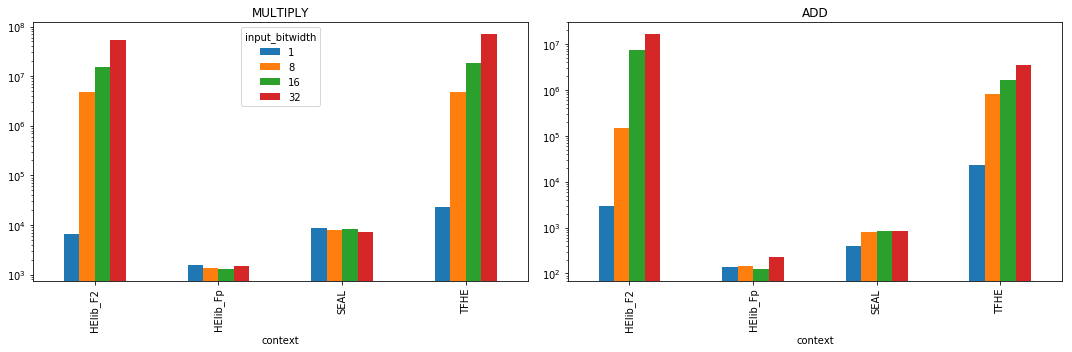

In [68]:
all_ops = set(df_scan3.gate)
is_signed = False
for i, op in enumerate(all_ops):
    libs = ["HElib_F2", "TFHE","SEAL","HElib_Fp"]
    rows = execution_time_vs_bitwidth(df_scan3, op, is_signed, libs)
    
    axis = plt.subplot((len(all_ops) + 2 // 2) // 2, 2, i + 1)
    axis.set_yscale("log")
    rows.plot(ax=axis, title=op , kind='bar', figsize=(15, 5), legend=False if i!=0 else True)
plt.tight_layout()
plt.show()